In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
import subprocess
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.ion() 

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Task 3

We have Lamoda and Wildberries clothes dataset. We need to train a classifier to predict the category of piece of clothes by the image of it from online shop.

## Data preprocessing

### Merging labels

In [6]:
SOURCE_DATA_PATH = 'C:\PythonDev\Projects\sex_clothes_classifier\data\_data\_data'

In [7]:
images_lamoda = os.listdir(f"{SOURCE_DATA_PATH}\lamoda\images")
images_wildberries =  os.listdir(f"{SOURCE_DATA_PATH}\wildberries\images")

In [8]:
!cd _data && mkdir images

���⥬� �� 㤠���� ���� 㪠����� ����.


In [9]:
for idx in range(len(images_lamoda)):
    shutil.move(f"{SOURCE_DATA_PATH}\lamoda\images\{images_lamoda[idx]}",
                f"{SOURCE_DATA_PATH}\lamoda\images\{images_lamoda[idx]}")
for idx in range(len(images_wildberries)):
    shutil.move(f"{SOURCE_DATA_PATH}\wildberries\images\{images_wildberries[idx]}",
                f"{SOURCE_DATA_PATH}\wildberries\images\{images_wildberries[idx]}")

In [10]:
lamoda_labels = pd.read_csv(f'{SOURCE_DATA_PATH}\lamoda\pages_info.tsv', sep='\t')
wildberries_labels = pd.read_csv(f'{SOURCE_DATA_PATH}\wildberries\pages_info.tsv', sep='\t')
wildberries_labels = wildberries_labels.drop(wildberries_labels[wildberries_labels['gender'] == 'женские / для девочек / мом фит / бананы / балоны / багги / слоучи / кюлоты'].index)
wildberries_labels = wildberries_labels.drop(wildberries_labels[wildberries_labels['category'] == '/catalog/48833592/detail.aspx?targetUrl=GP'].index)
wildberries_labels['item_id'] = wildberries_labels['item_id'].fillna(0.0).astype(int)

In [11]:
classification_labels = pd.concat([lamoda_labels, wildberries_labels], axis=0)
classification_labels = classification_labels.drop(classification_labels[classification_labels.item_id==0].index)
classification_labels['item_id'] = classification_labels['item_id'].fillna(0.0).astype(str)
classification_labels.reset_index(inplace=True)
del classification_labels['index']
classification_labels = classification_labels.sample(frac=1).reset_index(drop=True)

In [12]:
classification_labels.head()

gender  category                 brand subcategory  \
0  женский     брюки                 foley       брюки   
1  женский       топ                 oodji         топ   
2  женский  футболка  aeronautica militare    футболка   
3  женский       топ             bona fide         топ   
4  женский     шорты              viaville       шорты   

                                            item_url  \
0         /catalog/49235778/detail.aspx?targetUrl=GP   
1          /catalog/8756870/detail.aspx?targetUrl=GP   
2  /p/rtlaaa037201/clothes-aeronauticamilitare-fu...   
3         /catalog/35684973/detail.aspx?targetUrl=GP   
4         /catalog/39541422/detail.aspx?targetUrl=GP   

                                             img_url       item_id   price  \
0  https://images.wbstatic.net/c516x688/new/49230...      49235778  2350.0   
1  https://images.wbstatic.net/c516x688/new/87500...       8756870     0.0   
2  http://a.lmcdn.ru/img236x341/R/T/RTLAAA037201_...  RTLAAA037201  9700.0   
3  https://images.wbstatic.net/c516x688/new/35680...      35684973  2350.0   
4  https://images.wbstatic.net/c516x688/new/39540...      39541422  3840.0   

   price_discount  popular_flg      premium  size  colour  material  \
0          1145.0            1  non-premium   NaN     NaN       NaN   
1             0.0            0  non-premium   NaN     NaN       NaN   
2          4947.0            1  non-premium   NaN     NaN       NaN   
3          1598.0            0  non-premium   NaN     NaN       NaN   
4          3072.0            0  non-premium   NaN     NaN       NaN   

   novice_flg  rating  num_reviews  description  
0         NaN     NaN          NaN          NaN  
1         NaN     NaN          NaN          NaN  
2         NaN     NaN          NaN          NaN  
3         NaN     NaN          NaN          NaN  
4         NaN     NaN          NaN          NaN

In [13]:
classification_labels.category.unique()

array(['брюки', 'топ', 'футболка', 'шорты', 'купальник', 'юбка',
       'свитшот', 'водолазка', 'пиджак', 'поло', 'рубашка', 'толстовка',
       'жилет', 'свитер', 'платье', 'джинсы', 'жакет', 'кардиган',
       'джемпер', 'блузка', 'пуловер', 'костюм'], dtype=object)

### Creating folders with images

In [14]:
!mkdir type_of_images 

�������� ��� 䠩� type_of_images 㦥 �������.


In [15]:
!cd type_of_images && mkdir valid

�������� ��� 䠩� valid 㦥 �������.


In [16]:
!cd type_of_images && mkdir train

�������� ��� 䠩� train 㦥 �������.


In [17]:
for elem in lamoda_labels.category.unique():
    subprocess.run([f"cd type_of_images/train && mkdir {elem}"], shell=True)
    subprocess.run([f"cd type_of_images/valid && mkdir {elem}"], shell=True)

### Train/Validation split

In [18]:
category_df = pd.DataFrame(classification_labels.groupby('category').img_url.nunique())
category_df.reset_index(level=0, inplace=True)
category_df.columns = ['category', 'count']

In [19]:
category_df

category  count
0      блузка    960
1       брюки   1937
2   водолазка   1938
3     джемпер   1920
4      джинсы   1931
5       жакет    949
6       жилет   1470
7    кардиган   1949
8      костюм    377
9   купальник    616
10     пиджак   1897
11     платье    976
12       поло   1911
13    пуловер    878
14    рубашка   1898
15     свитер   1300
16    свитшот   1940
17  толстовка    918
18        топ    956
19   футболка   1924
20      шорты   1956
21       юбка    932

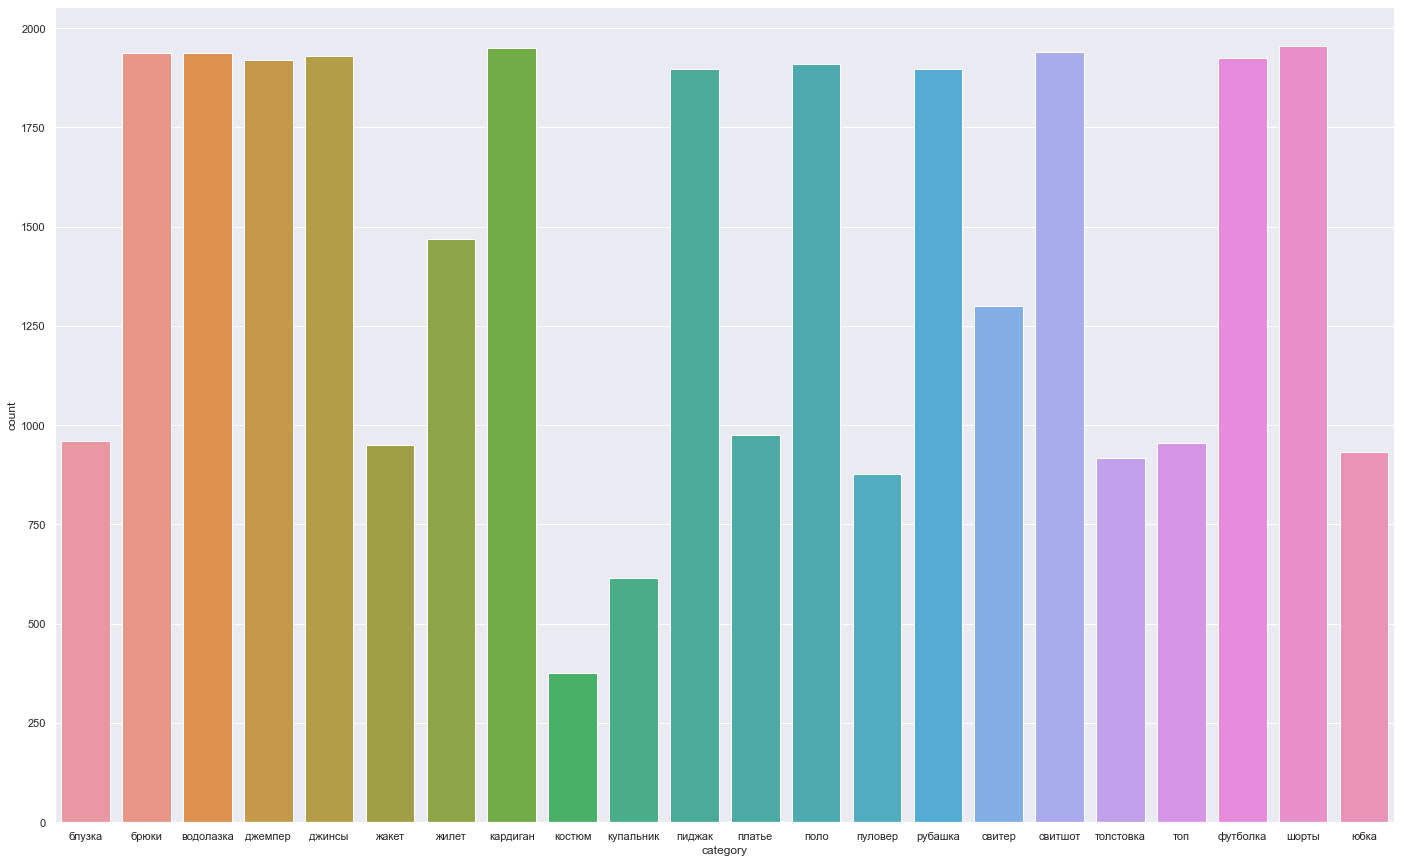

In [20]:
sns.set_theme(style="whitegrid")

tips = sns.load_dataset("tips")
sns.set(rc={'figure.figsize':(24,15)})
ax = sns.barplot(x="category", y="count", data=category_df)

In [21]:
dict_test = {list(classification_labels.category.unique())[idx] : idx for idx in range(len(classification_labels.category.unique()))}

In [ ]:
model_resnet = models.resnet18(pretrained=False)
model_resnet.fc = nn.Linear(in_features=512, out_features=len(image_datasets['train'].classes), bias=True)
model_resnet = model_resnet.to(device)

In [22]:
for idx in range(len(classification_labels.category.unique())):
    type_of_clothing = classification_labels.category.unique()[idx]
    classification_labels['category'][classification_labels['category'] == f'{type_of_clothing}'] = idx

In [23]:
images_all = os.listdir(f"{SOURCE_DATA_PATH}/images")

In [28]:
SOURCE_PATH = 'C:\PythonDev\Projects\sex_clothes_classifier\data'

In [30]:
for key, value in dict_test.items():
    df_tmp = classification_labels[classification_labels.category==value]
    df_tmp_valid = df_tmp[:int(.2*len(df_tmp))]
    df_tmp_train = df_tmp[int(.2*len(df_tmp)):]
    for idx in range(len(df_tmp_valid)):
        try:
            if f"{df_tmp_valid.iloc[idx].item_id}.jpg" in images_all:
                shutil.move(f"{SOURCE_PATH}\images\{df_tmp_valid.iloc[idx].item_id}.jpg",
                    f"{SOURCE_PATH}\\type_of_images\valid\{key}\{df_tmp_valid.iloc[idx].item_id}.jpg")
        except:
            pass
    for idx in range(len(df_tmp_train)):
        try:
            if f"{df_tmp_train.iloc[idx].item_id}.jpg" in images_all:
                shutil.move(f"{SOURCE_DATA_PATH}/images/{df_tmp_train.iloc[idx].item_id}.jpg",
                    f"{SOURCE_PATH}/type_of_images/train/{key}/{df_tmp_train.iloc[idx].item_id}.jpg")
        except:
            pass

## Dataloader

Albumentations will be an overkill here

In [33]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomAutocontrast(),
        # transforms.Grayscale(),
        # transforms.RandomAdjustSharpness(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\PythonDev\Projects\sex_clothes_classifier\data\\types_of_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

In [ ]:
dataloader_train = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=512,
                                             shuffle=True, num_workers=4) for x in ['train']}
dataloader_valid = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=512,
                                             shuffle=True, num_workers=4) for x in ['valid']}
dataloaders = {**dataloader_train, **dataloader_valid}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
image_datasets['train'].classes

['блузка',
 'брюки',
 'водолазка',
 'джемпер',
 'джинсы',
 'жакет',
 'жилет',
 'кардиган',
 'костюм',
 'купальник',
 'пиджак',
 'платье',
 'поло',
 'пуловер',
 'рубашка',
 'свитер',
 'свитшот',
 'толстовка',
 'топ',
 'футболка',
 'шорты',
 'юбка']

In [6]:
dataset_sizes

{'train': 25234, 'valid': 6299}

## Train model

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We are choosing Resnet18 as balanced model between inference/quality of prediction

In [60]:
model_resnet = models.resnet18(pretrained=False)
model_resnet.fc = nn.Linear(in_features=512, out_features=len(image_datasets['train'].classes), bias=True)
model_resnet = model_resnet.to(device)

In [61]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [62]:
model_resnet = train_model(model_resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.5396 Acc: 0.2139
valid Loss: 2.9534 Acc: 0.1600

Epoch 1/29
----------
train Loss: 1.9662 Acc: 0.3647
valid Loss: 2.3040 Acc: 0.2905

Epoch 2/29
----------
train Loss: 1.6589 Acc: 0.4638
valid Loss: 1.9281 Acc: 0.4128

Epoch 3/29
----------
train Loss: 1.4411 Acc: 0.5316
valid Loss: 1.7939 Acc: 0.4417

Epoch 4/29
----------
train Loss: 1.2522 Acc: 0.5957
valid Loss: 1.8661 Acc: 0.4250

Epoch 5/29
----------
train Loss: 1.0563 Acc: 0.6596
valid Loss: 1.2712 Acc: 0.5863

Epoch 6/29
----------
train Loss: 0.9571 Acc: 0.6931
valid Loss: 1.2173 Acc: 0.6039

Epoch 7/29
----------
train Loss: 0.9094 Acc: 0.7081
valid Loss: 1.1750 Acc: 0.6152

Epoch 8/29
----------
train Loss: 0.8664 Acc: 0.7253
valid Loss: 1.1805 Acc: 0.6176

Epoch 9/29
----------
train Loss: 0.8256 Acc: 0.7414
valid Loss: 1.1565 Acc: 0.6244

Epoch 10/29
----------
train Loss: 0.7790 Acc: 0.7583
valid Loss: 1.1322 Acc: 0.6344

Epoch 11/29
----------
train Loss: 0.7700 Acc: 0.7581
valid Loss

KeyboardInterrupt: 

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], title=f"predicted: {class_names[preds[j]]}")

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

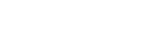

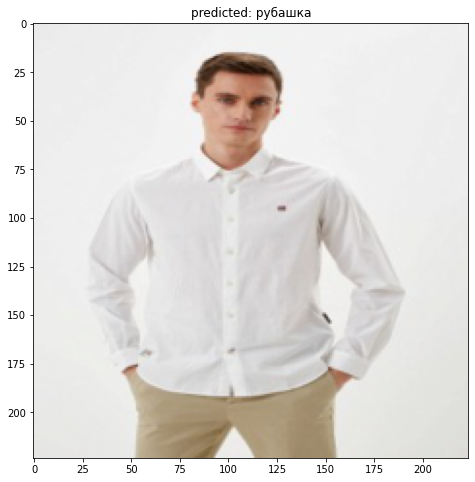

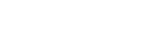

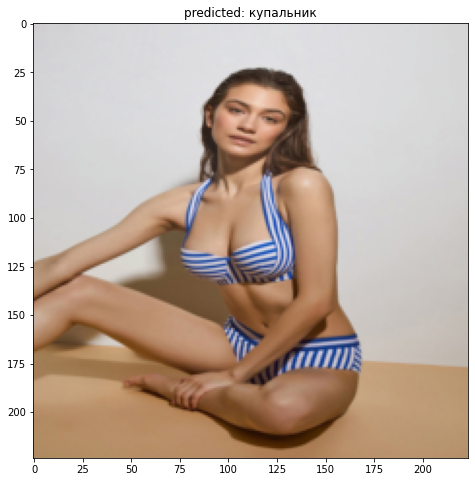

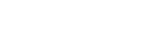

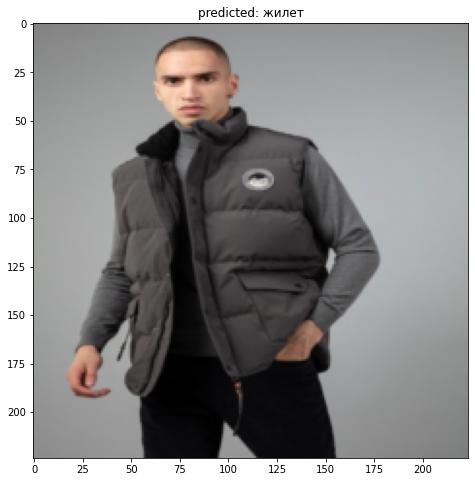

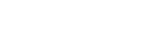

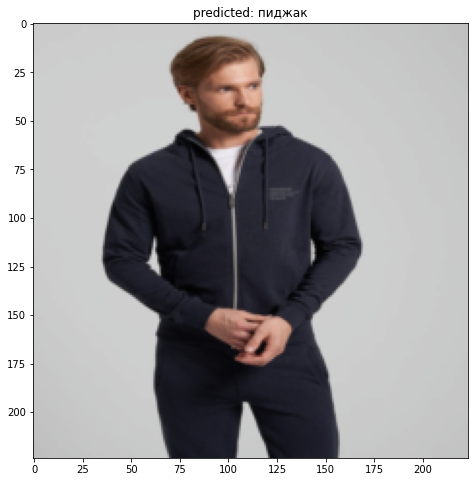

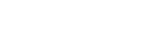

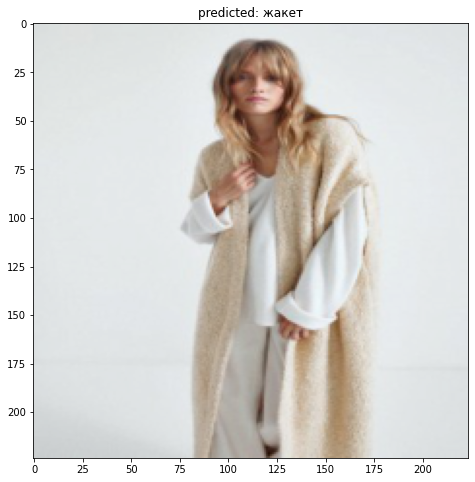

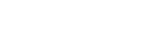

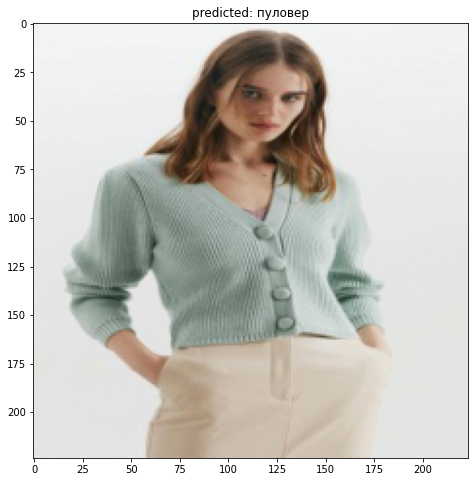

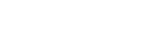

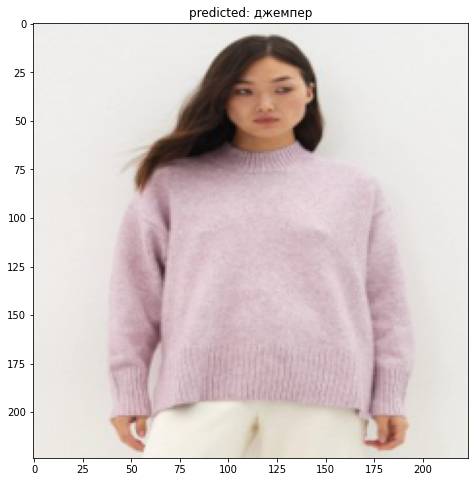

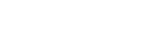

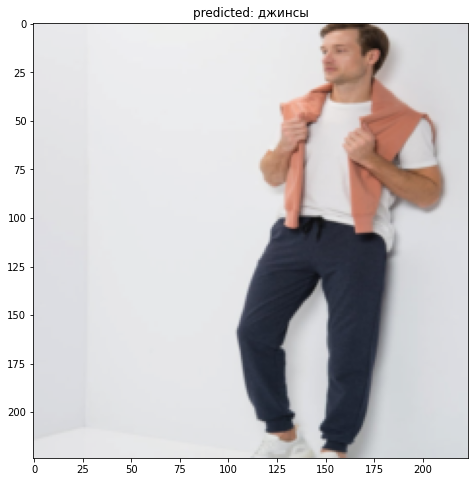

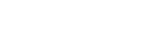

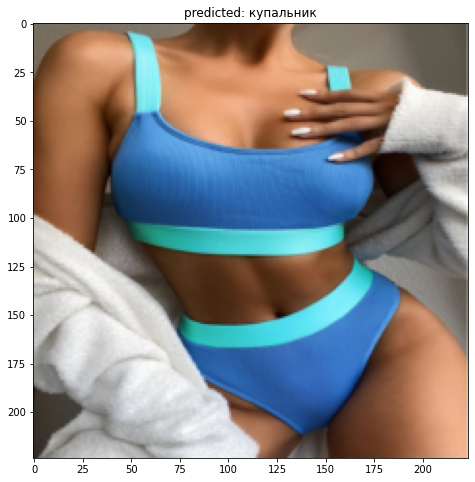

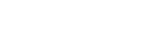

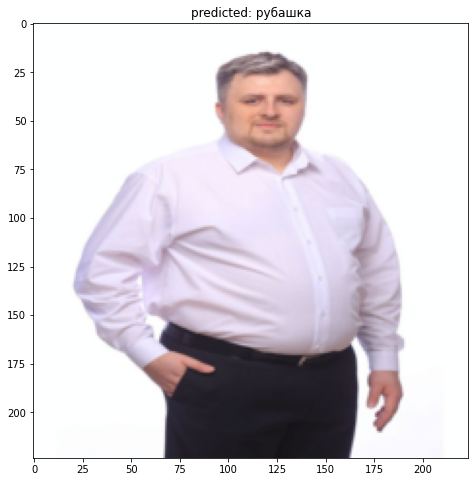

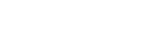

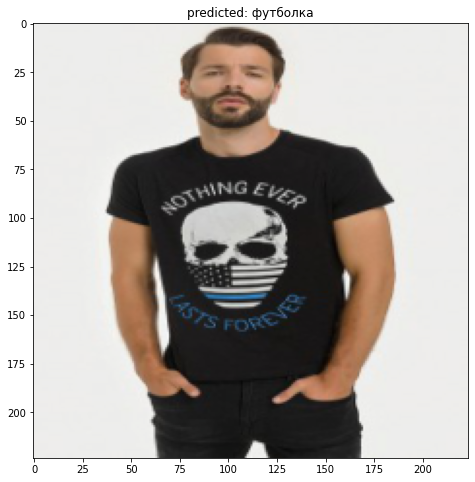

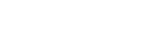

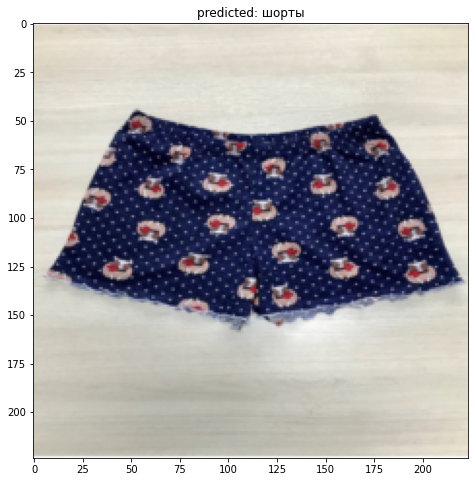

In [71]:
visualize_model(model_resnet)

In [66]:
torch.save(model_resnet.state_dict(), 'model_resnet18_clothes_class.pth')

## Quantization

In [67]:
from torch.quantization import convert
model_resnet_quantized = convert(model_resnet, inplace=False)

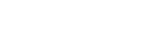

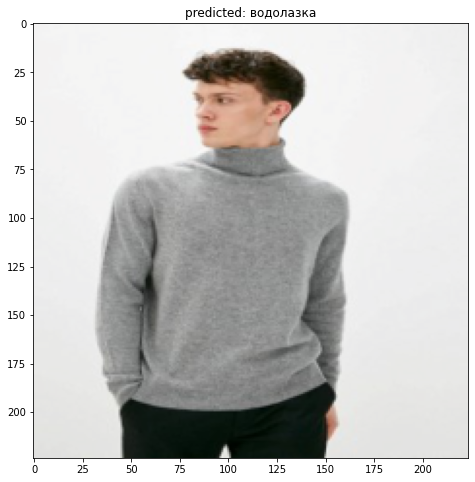

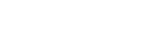

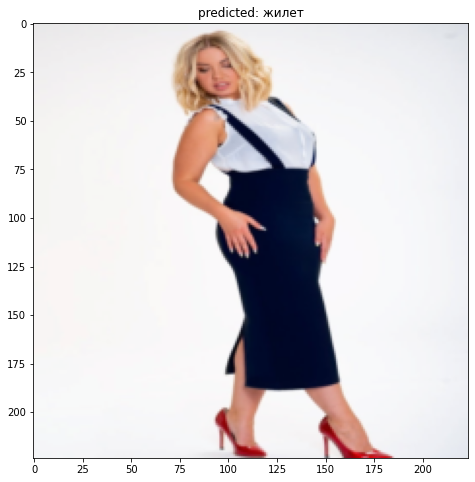

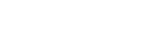

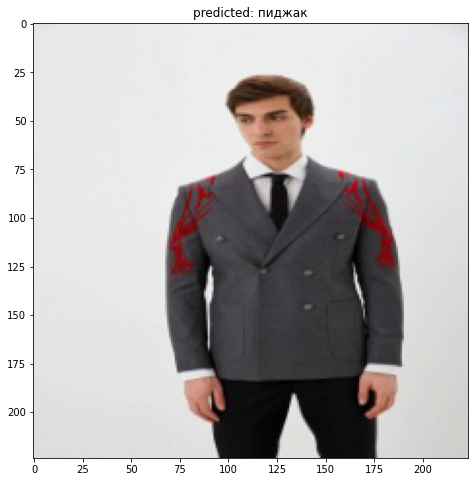

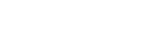

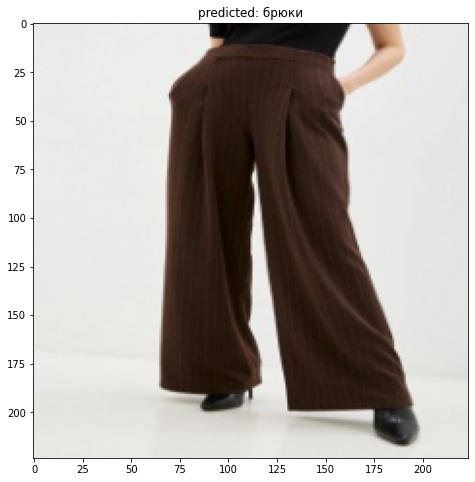

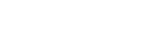

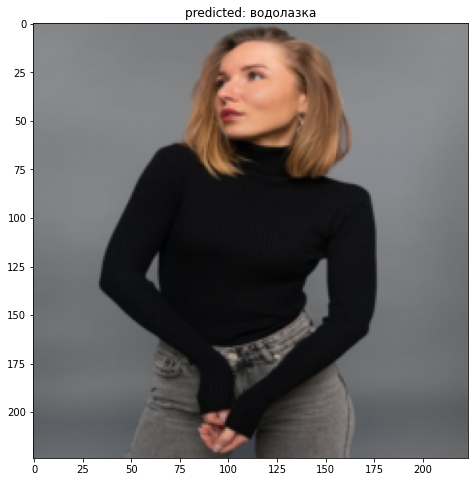

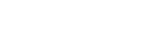

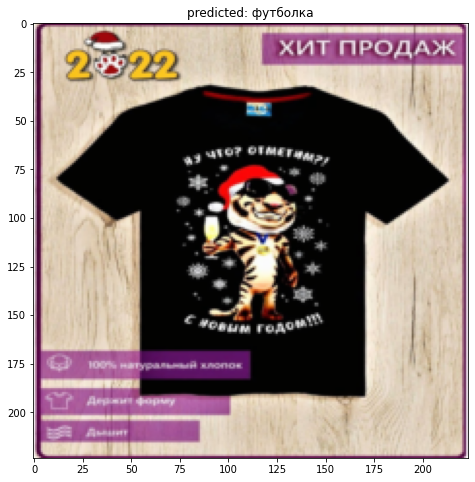

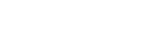

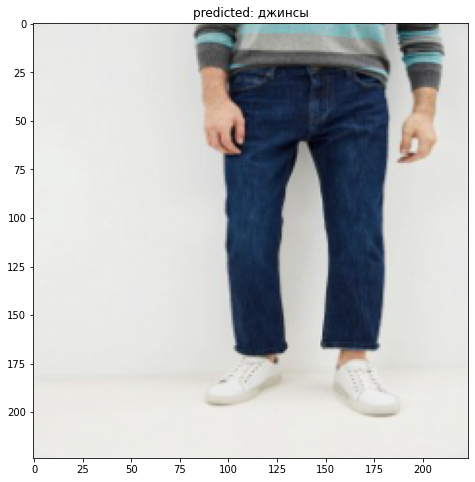

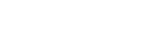

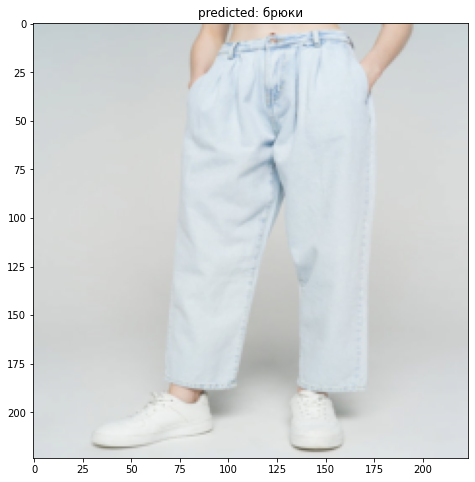

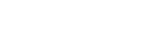

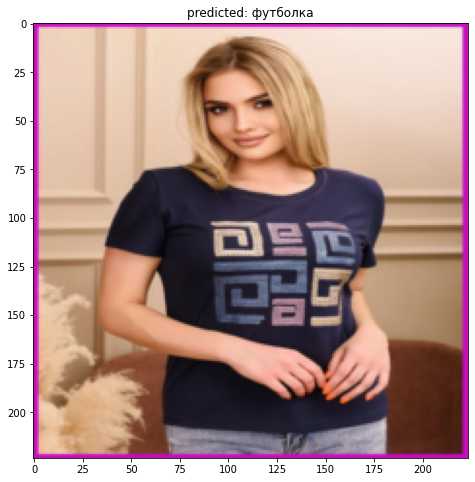

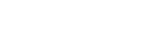

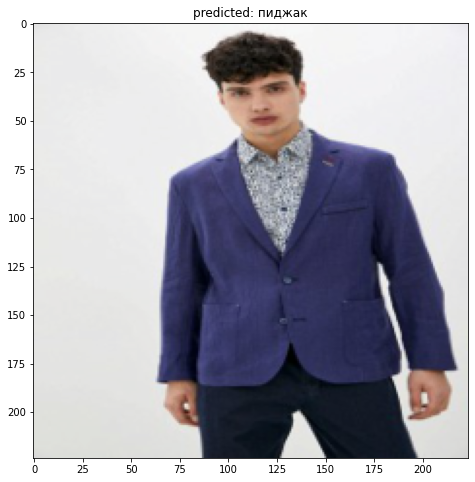

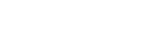

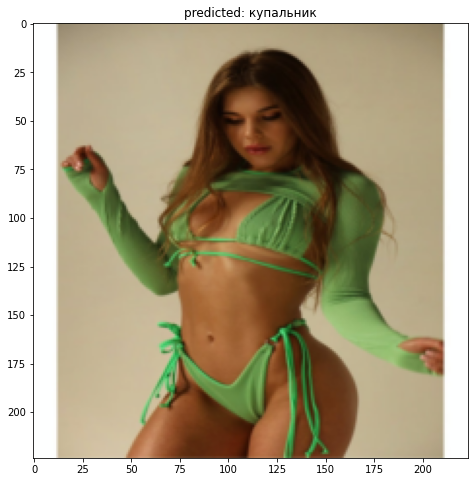

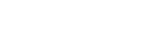

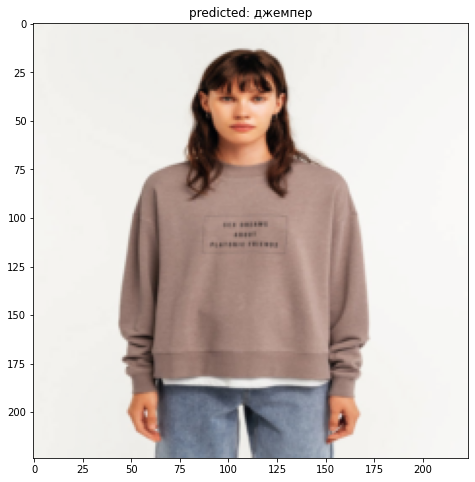

In [68]:
visualize_model(model_resnet_quantized)

In [72]:
torch.save(model_resnet.state_dict(), 'model_resnet18_quantized_clothes_class.pth')

## Transfering model to mobilenet

In [73]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
scripted_model = torch.jit.script(model_resnet_quantized)
optimized_model = optimize_for_mobile(scripted_model, backend='Vulkan')
print(torch.jit.export_opnames(optimized_model))
optimized_model._save_for_lite_interpreter('./model_resnet18_clothes_class_Vulkan.pt')

['aten::__getitem__.t', 'aten::adaptive_avg_pool2d', 'aten::add.Scalar', 'aten::add.int', 'aten::add_.Tensor', 'aten::addmm', 'aten::batch_norm', 'aten::conv2d', 'aten::dim', 'aten::eq.int', 'aten::flatten.using_ints', 'aten::format', 'aten::gt.int', 'aten::len.t', 'aten::matmul', 'aten::max_pool2d', 'aten::mul.int', 'aten::ne.int', 'aten::relu_', 'aten::size', 'aten::sub.int', 'aten::t', 'prim::RaiseException']


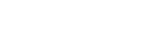

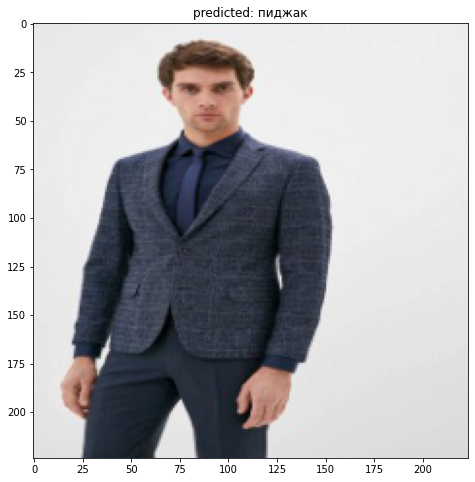

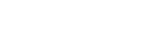

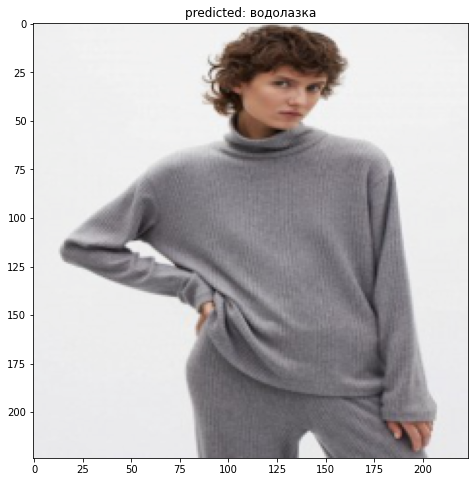

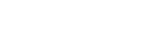

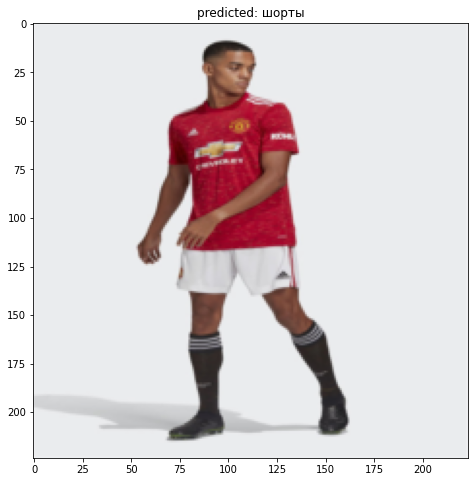

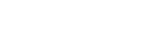

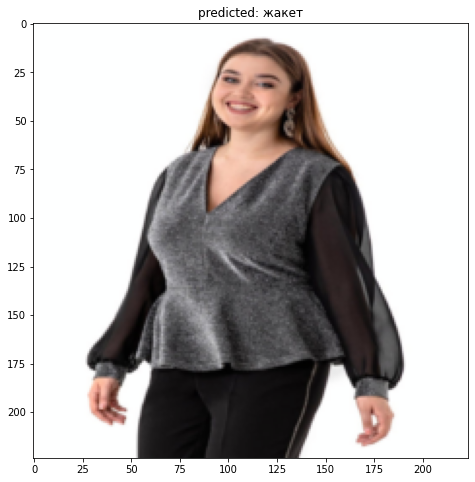

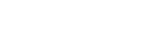

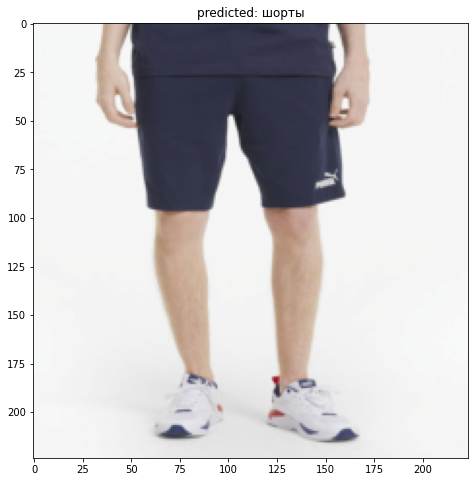

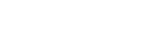

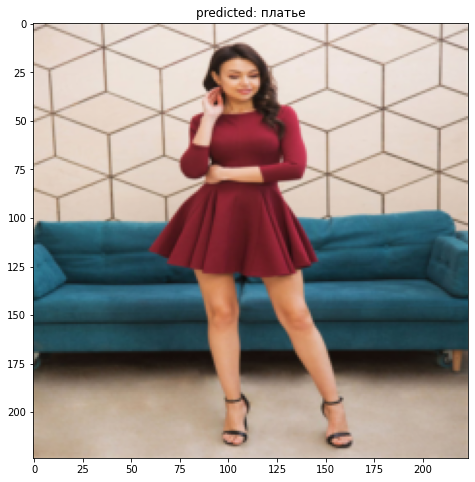

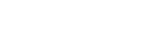

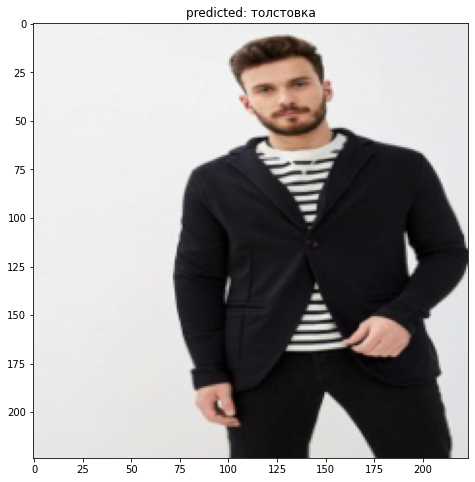

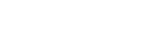

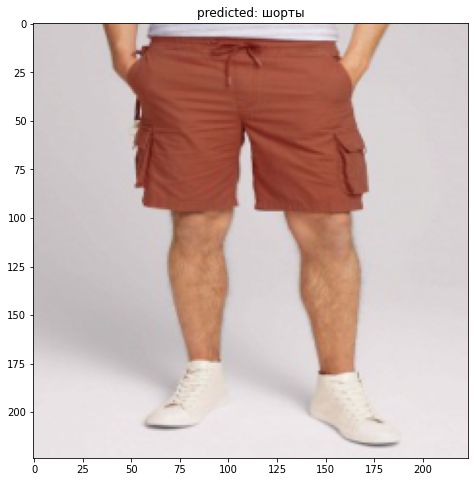

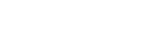

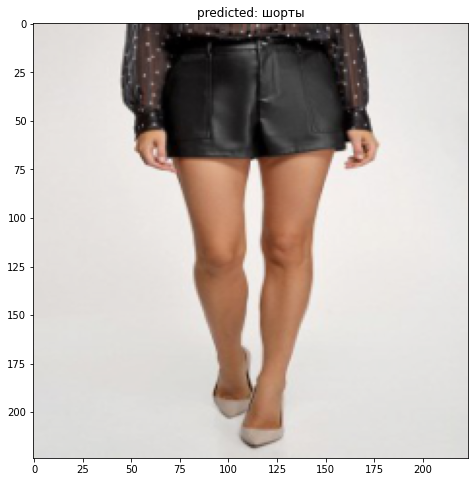

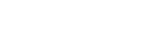

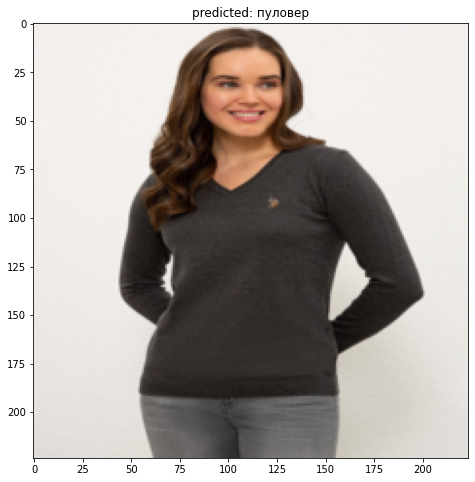

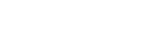

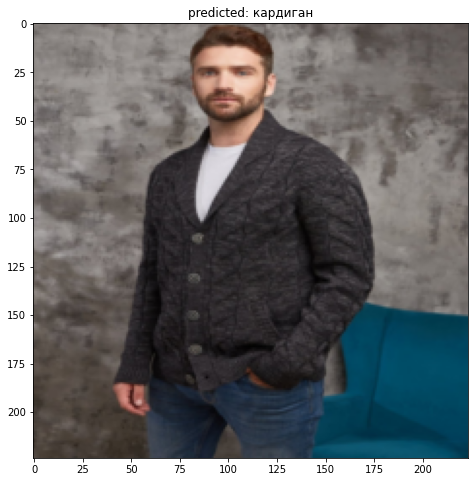

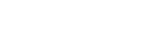

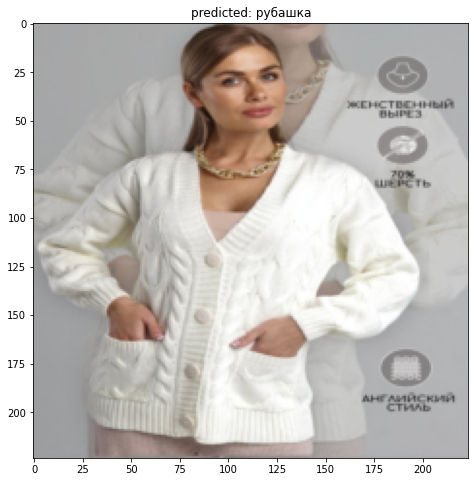

In [77]:
visualize_model(optimized_model)

## MobileNet V2

In [10]:
model_mobilenet_v2 = models.mobilenet_v2(pretrained=False)
model_mobilenet_v2.classifier[1] = nn.Linear(in_features=1280, out_features=len(image_datasets['train'].classes), bias=True)
model_mobilenet_v2.load_state_dict(torch.load("C:\PythonDev\Projects\sex_clothes_classifier\weights\model_mobilenet_v2_clothes_class_v1.pth"))
model_mobilenet_v2 = model_mobilenet_v2.to(device)

In [20]:
lr = 1e-5
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mobilenet_v2.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_mobilenet_v2 = train_model(model_mobilenet_v2, criterion, optimizer, scheduler, num_epochs=epoch)

Epoch 0/99
----------
train Loss: 1.3851 Acc: 0.5505
valid Loss: 2.1780 Acc: 0.3345

Epoch 1/99
----------
train Loss: 1.3756 Acc: 0.5551
valid Loss: 2.1854 Acc: 0.3331

Epoch 2/99
----------
train Loss: 1.3838 Acc: 0.5515
valid Loss: 2.1862 Acc: 0.3366

Epoch 3/99
----------
train Loss: 1.3825 Acc: 0.5500
valid Loss: 2.1818 Acc: 0.3305

Epoch 4/99
----------
train Loss: 1.3762 Acc: 0.5514
valid Loss: 2.1897 Acc: 0.3334

Epoch 5/99
----------
train Loss: 1.3635 Acc: 0.5577
valid Loss: 2.1835 Acc: 0.3356

Epoch 6/99
----------
train Loss: 1.3888 Acc: 0.5501
valid Loss: 2.1828 Acc: 0.3356

Epoch 7/99
----------
train Loss: 1.3710 Acc: 0.5575
valid Loss: 2.1850 Acc: 0.3347

Epoch 8/99
----------
train Loss: 1.3697 Acc: 0.5548
valid Loss: 2.1882 Acc: 0.3345

Epoch 9/99
----------
train Loss: 1.3715 Acc: 0.5550
valid Loss: 2.1854 Acc: 0.3345

Epoch 10/99
----------
train Loss: 1.3736 Acc: 0.5526
valid Loss: 2.1778 Acc: 0.3316

Epoch 11/99
----------


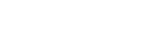

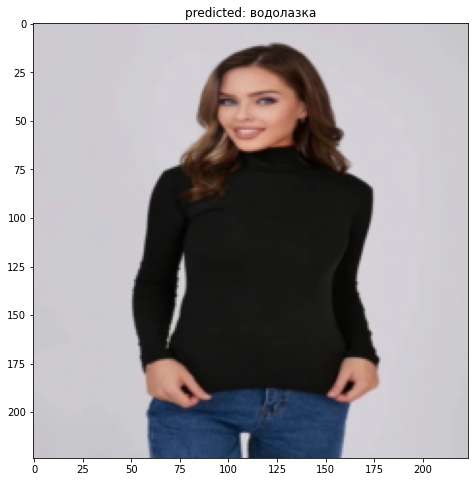

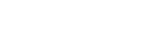

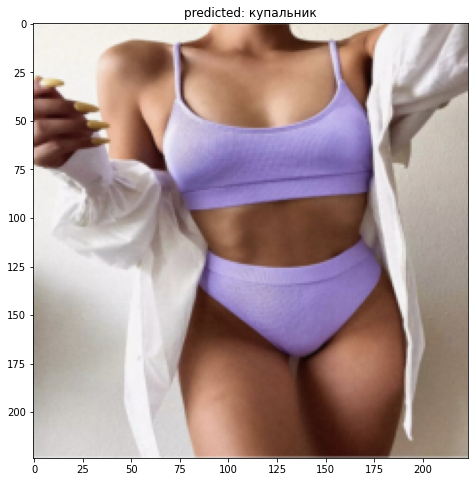

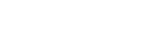

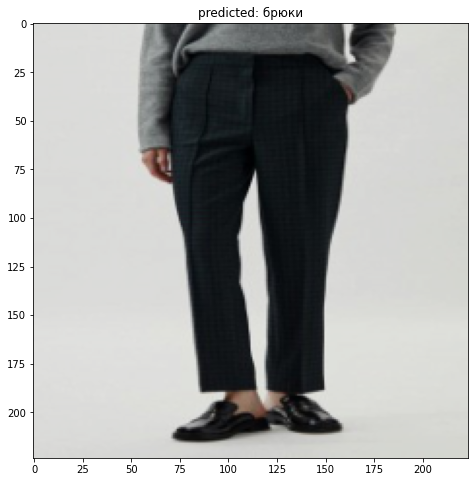

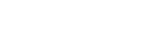

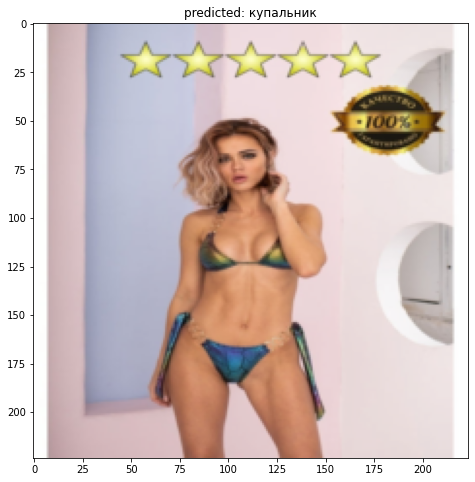

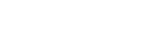

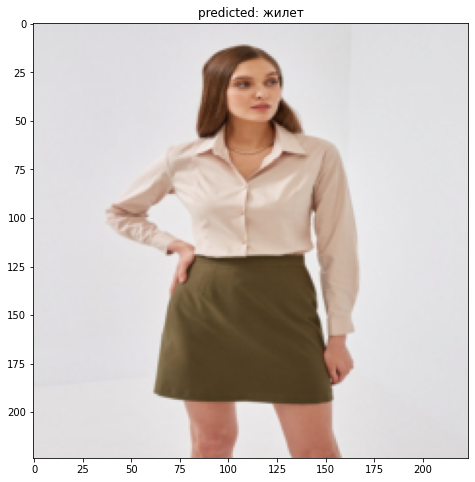

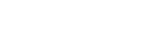

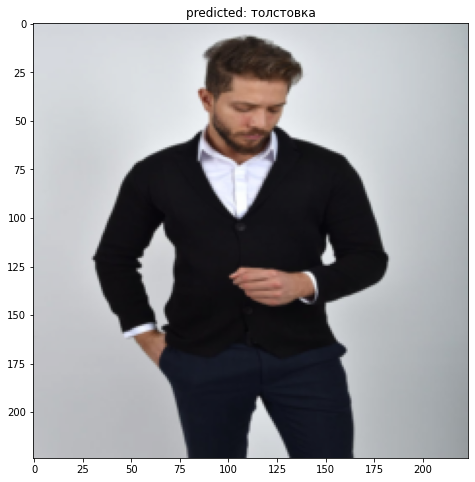

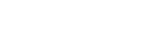

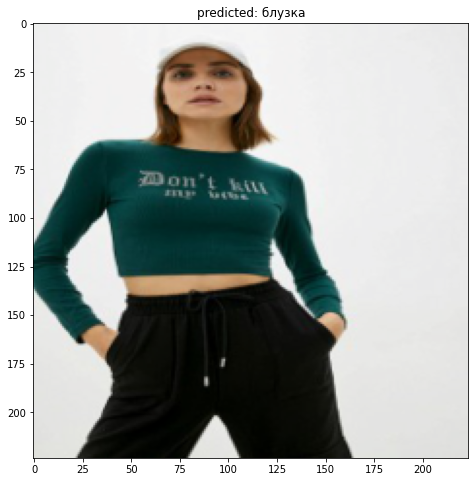

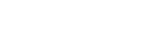

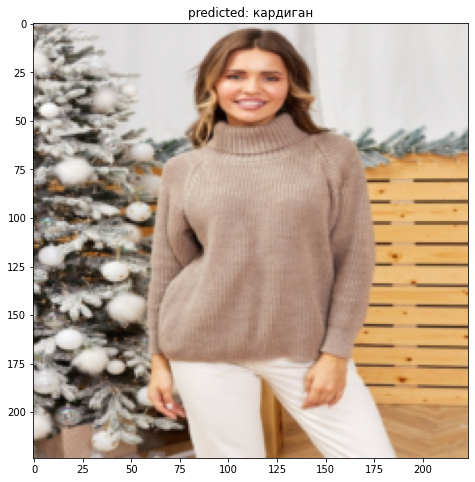

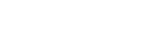

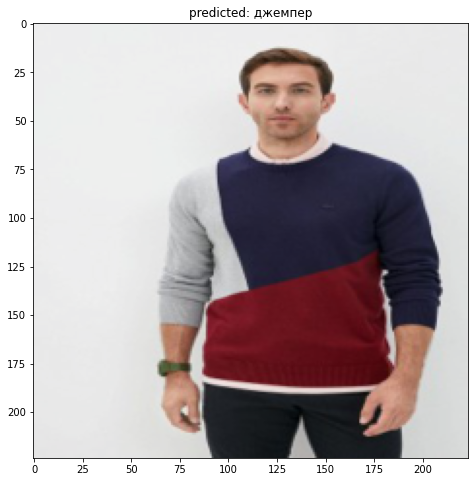

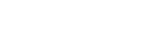

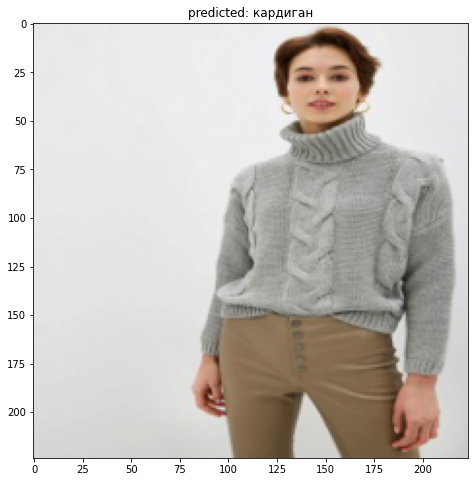

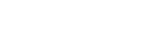

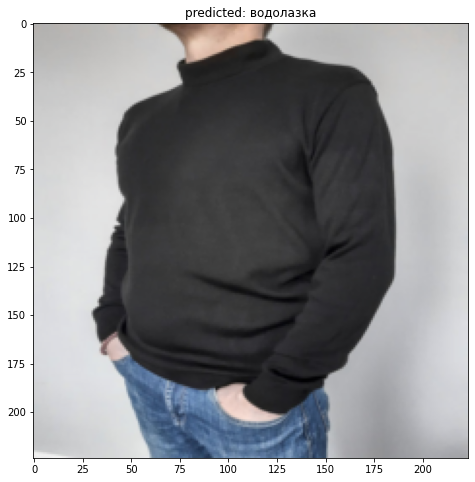

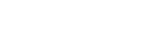

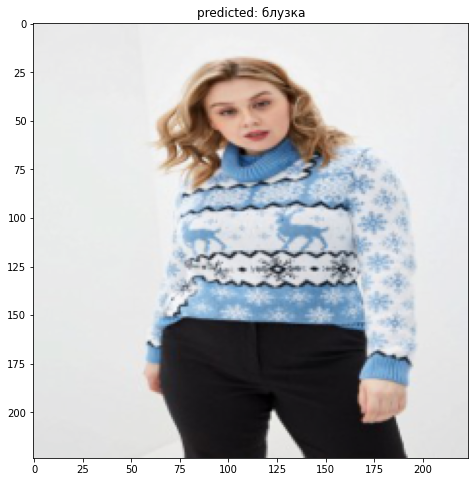

In [14]:
visualize_model(model_mobilenet_v2)

In [ ]:
torch.save(model_mobilenet_v2.state_dict(), 'model_mobilenet_v2_clothes_class_v2.pth')